In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

!['Demand classification'](https://miro.medium.com/v2/resize:fit:1400/format:webp/0*KQQmtAONkr_g8Smo.png )

```
Based on these 2 dimensions, the literature classifies the demand profiles into 4 different categories:

Smooth demand (ADI < 1.32 and CV² < 0.49). The demand is very regular in time and in quantity. It is therefore easy to forecast and you won’t have trouble reaching a low forecasting error level.
Intermittent demand (ADI >= 1.32 and CV² < 0.49). The demand history shows very little variation in demand quantity but a high variation in the interval between two demands. Though specific forecasting methods tackle intermittent demands, the forecast error margin is considerably higher.
Erratic demand (ADI < 1.32 and CV² >= 0.49). The demand has regular occurrences in time with high quantity variations. Your forecast accuracy remains shaky.
Lumpy demand (ADI >= 1.32 and CV² >= 0.49). The demand is characterized by a large variation in quantity and in time. It is actually impossible to produce a reliable forecast, no matter which forecasting tools you use. This particular type of demand pattern is unforecastable.
Here, the metric is to blame.
```

In [69]:
df=pd.read_csv('twentyeleven.csv')

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 484330 entries, 0 to 484329
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Invoice      484329 non-null  float64
 1   StockCode    484330 non-null  object 
 2   Description  484330 non-null  object 
 3   Quantity     484330 non-null  int64  
 4   InvoiceDate  484330 non-null  object 
 5   Price        484330 non-null  float64
 6   Customer ID  367058 non-null  float64
 7   Country      484330 non-null  object 
 8   date         484330 non-null  object 
 9   revenue      484330 non-null  float64
 10  year         484330 non-null  int64  
dtypes: float64(4), int64(2), object(5)
memory usage: 40.6+ MB


In [71]:
df=pd.read_csv('twentyeleven.csv')

In [72]:
df['InvoiceDate']=pd.to_datetime(df['InvoiceDate'])

In [73]:
df['daysofweek']=df['InvoiceDate'].dt.dayofweek

In [74]:
df['daysofweek'].value_counts()

daysofweek
3    92832
1    92491
0    84860
2    84439
4    71849
6    57859
Name: count, dtype: int64

In [75]:
df['InvoiceDate']=df['InvoiceDate'].dt.strftime('%Y-%m-%d')

In [76]:
df['date']=pd.to_datetime(df['date'])

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 484330 entries, 0 to 484329
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      484329 non-null  float64       
 1   StockCode    484330 non-null  object        
 2   Description  484330 non-null  object        
 3   Quantity     484330 non-null  int64         
 4   InvoiceDate  484330 non-null  object        
 5   Price        484330 non-null  float64       
 6   Customer ID  367058 non-null  float64       
 7   Country      484330 non-null  object        
 8   date         484330 non-null  datetime64[ns]
 9   revenue      484330 non-null  float64       
 10  year         484330 non-null  int64         
 11  daysofweek   484330 non-null  int32         
dtypes: datetime64[ns](1), float64(4), int32(1), int64(2), object(4)
memory usage: 42.5+ MB


In [78]:
retail_grouped=df.groupby(['Description','date'],as_index=False).aggregate(total_sales=('Quantity','sum'))

In [79]:
cv_data=retail_grouped.groupby(['Description']).agg(avg=('total_sales','mean'),sd=('total_sales','std')).reset_index()

In [80]:
cv_data

,Description,avg,sd
0,10 COLOUR SPACEBOY PEN,36.030120,46.870217
1,12 COLOURED PARTY BALLOONS,18.017391,16.152770
2,12 DAISY PEGS IN WOOD BOX,5.533333,6.379168
3,12 EGG HOUSE PAINTED WOOD,1.864865,1.306719
4,12 HANGING EGGS HAND PAINTED,6.666667,3.669696
...,...,...,...
3955,wrongly coded 20713,800.000000,NaN
3956,wrongly coded 23343,1000.000000,NaN
3957,wrongly marked,48.000000,NaN
3958,wrongly marked 23343,200.000000,NaN


In [81]:
cv_data['cv_squared']= (cv_data['sd']/cv_data['avg'])**2

In [82]:
prod_by_date=df.groupby(['Description','date']).agg(count=('Description','count')).reset_index()

In [83]:
skus=prod_by_date.Description.unique()


In [84]:
len(skus)

3960

In [48]:
empty_df=pd.DataFrame()

In [85]:
for sku in tqdm(skus):
    a=prod_by_date[prod_by_date.Description==sku]
    a['prev_date']=a['date'].shift(1)
    empty_df=pd.concat([empty_df,a],axis=0)


100%|██████████████████████████████████████████████████████████████████████████████| 3960/3960 [01:46<00:00, 37.15it/s]


In [86]:
empty_df['duration']=empty_df['date'] -empty_df['prev_date']

In [87]:
empty_df

,Description,date,count,prev_date,duration
0,10 COLOUR SPACEBOY PEN,2011-01-05,1,NaT,NaT
1,10 COLOUR SPACEBOY PEN,2011-01-06,3,2011-01-05,1 days
2,10 COLOUR SPACEBOY PEN,2011-01-09,3,2011-01-06,3 days
3,10 COLOUR SPACEBOY PEN,2011-01-11,1,2011-01-09,2 days
4,10 COLOUR SPACEBOY PEN,2011-01-13,2,2011-01-11,2 days
...,...,...,...,...,...
255715,wrongly coded 20713,2011-10-06,1,NaT,NaT
255716,wrongly coded 23343,2011-10-27,1,NaT,NaT
255717,wrongly marked,2011-10-31,1,NaT,NaT
255718,wrongly marked 23343,2011-10-24,1,NaT,NaT


In [88]:
empty_df['duration']=empty_df['duration'].astype('string').str.replace('days','')

In [89]:
empty_df['duration']=pd.to_numeric(empty_df['duration'],errors='coerce')

In [90]:

ADI=empty_df.groupby('Description').agg(ADI=('duration','mean')).reset_index()

In [91]:
ADI

,Description,ADI
0,10 COLOUR SPACEBOY PEN,2.048485
1,12 COLOURED PARTY BALLOONS,2.894737
2,12 DAISY PEGS IN WOOD BOX,4.745763
3,12 EGG HOUSE PAINTED WOOD,4.60274
4,12 HANGING EGGS HAND PAINTED,4.4
...,...,...
3955,wrongly coded 20713,<NA>
3956,wrongly coded 23343,<NA>
3957,wrongly marked,<NA>
3958,wrongly marked 23343,<NA>


In [92]:
adi_cv=pd.merge(ADI,cv_data)

In [100]:
adi_cv.fillna(0,inplace=True)

In [101]:
def categorize(df):
 
    if(df['ADI']<=1.34 and df['cv_squared']<0.49):
        return 'smooth'
    if(df['ADI']>1.34 and df['cv_squared']>=0.49):
        return 'lumpy'
    if(df['ADI']>1.34 and df['cv_squared']<0.49):
        return 'Intermittent'
    if(df['ADI']<=1.34 and df['cv_squared']>=0.49):
        return 'Erratic'


In [102]:
adi_cv['category']=adi_cv.apply(categorize,axis=1)

<Axes: xlabel='cv_squared', ylabel='ADI'>

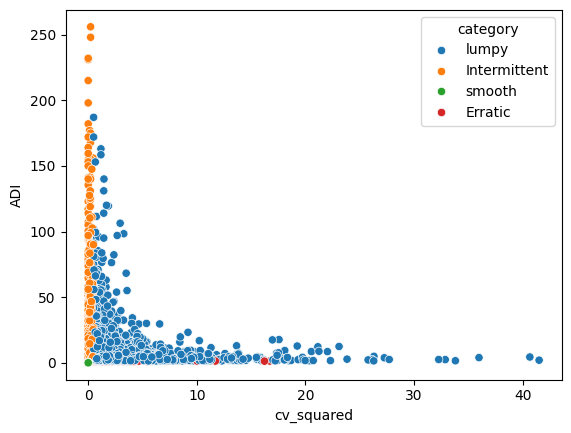

In [103]:
sns.scatterplot(x='cv_squared',y='ADI',hue='category',data=adi_cv)

In [104]:
adi_cv['category'].value_counts()

category
lumpy           3037
Intermittent     581
smooth           201
Erratic          141
Name: count, dtype: int64